In [274]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from skimage import io, filters, morphology
from skimage.draw import polygon 
from scipy.ndimage import minimum_filter, gaussian_filter1d, median_filter, gaussian_filter


%matplotlib widget

In [275]:
#image_path = "C:/Users/ica/OneDrive - Plymouth Marine Laboratory/vscode/whitecaps/data/Stbd_2011_07_13_15_00_00.jpg"
#Stbd_2011_06_29_16_00_00.jpg - little whitecaps 
#Stbd_2011_07_11_09_00_00 - big whitecaps
#Stbd_2011_07_07_21_00_00 - no whitecaps 
#Stbd_2011_07_13_15_00_00 -normal whitecaps? 

image_path = 'C:/Users/ica/OneDrive - Plymouth Marine Laboratory/vscode/whitecaps/2024-01-21T00-00-00Z-stbd.jpg'

In [276]:
im = io.imread(image_path).astype(np.float64)
#convert pixels into numbes


In [277]:

im=im/255
im_rg = (im[:,:,0] + im[:,:,1]) / 2
im_rg.min(), im_rg.max()
#turn into grayscale (0 to 1) 


(0.029411764705882353, 1.0)

In [259]:
   
def moving_min(block):
    '''
    np.nanmin(block): Finds the minimum value in the block, ignoring NaN values
    np.ones_like(block): Creates an array of the same shape as the input, filled with ones
    Multiplies the minimum value by an array of ones, effectively creating a block where every pixel is set to the minimum value
    '''
    return np.nanmin(block) * np.ones_like(block)

In [ ]:
#applies funciton with a 50x50 block for the whole image
background = ndi.minimum_filter(im_rg, size=(200, 200)) 
background =background-background.min()


average across columns, get a gradient per picture to see how you need to correft for brightness 

In [280]:
background_smoothed = filters.gaussian(background, sigma=1)  #backgorund should be less tahn 0.1

# Subtract background
im_subtracted = im_rg - background_smoothed

In [262]:
im_subtracted.min()

0.19411764705882353

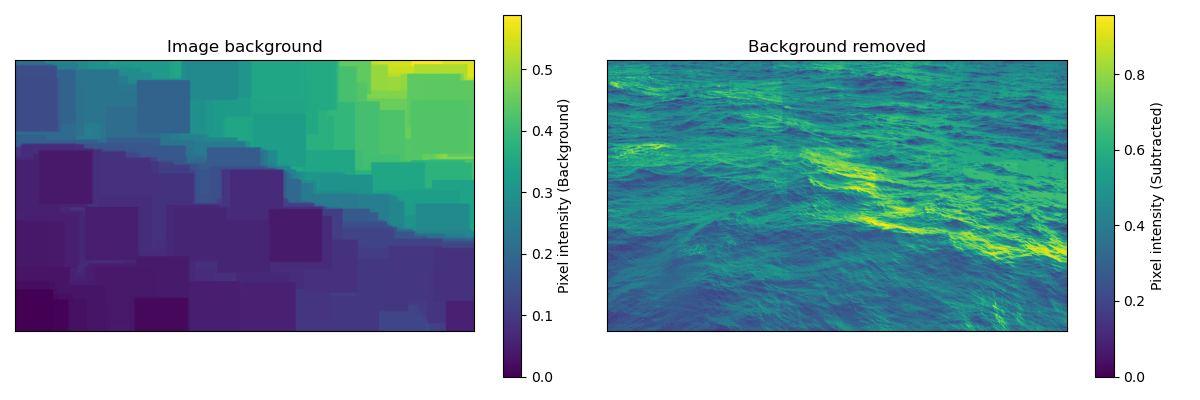

In [281]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Calculate the global min and max for consistent color scaling
vmin = min(background_smoothed.min(), im_subtracted.min())
vmax = max(background_smoothed.max(), im_subtracted.max())

# First image
im1 = ax1.imshow(background_smoothed, cmap='viridis')
ax1.set_title('Image background')
ax1.set_xticks([])
ax1.set_yticks([])
cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical', label='Pixel intensity (Background)')

# Second image
im2 = ax2.imshow(im_subtracted, cmap='viridis', vmin=vmin, vmax=vmax)
ax2.set_title('Background removed')
ax2.set_xticks([])
ax2.set_yticks([])
cbar2 = fig.colorbar(im2, ax=ax2, orientation='vertical', label='Pixel intensity (Subtracted)')

plt.tight_layout()
plt.show()


In [264]:
intensity_vector = np.arange(0, np.nanmax(im_subtracted)*0.9, 0.01)
'''
np.nanmax(im_subtracted): Finds the maximum intensity value in the image, ignoring NaN values.
*0.9: Multiplies by 0.9 to avoid extreme outliers at the maximum intensity.
np.arange(start, stop, step): Creates a range of intensity thresholds from 0 to 90% of the max intensity with a step size of 0.01. 
'''

# Calculate the PIP
hist, bin_edges = np.histogram(im_subtracted[~np.isnan(im_subtracted)], 
                                bins=intensity_vector)

'''
Counts how many pixel intensities fall within each range (bin) defined by the intensty vector
    Excludes NaN values to ensure valid calculations.
np.histogram: Computes the histogram, returning:
hist: Counts of pixels in each bin.
bin_edges: The boundaries of the bins.
'''

# Flip to start at highest intensity threshold to lowest
hist_reversed = np.flip(hist)
bin_edges_reversed = np.flip(bin_edges)



# Get cumulative sum at each successively lower intensity
cumulative_sum = np.cumsum(hist_reversed)

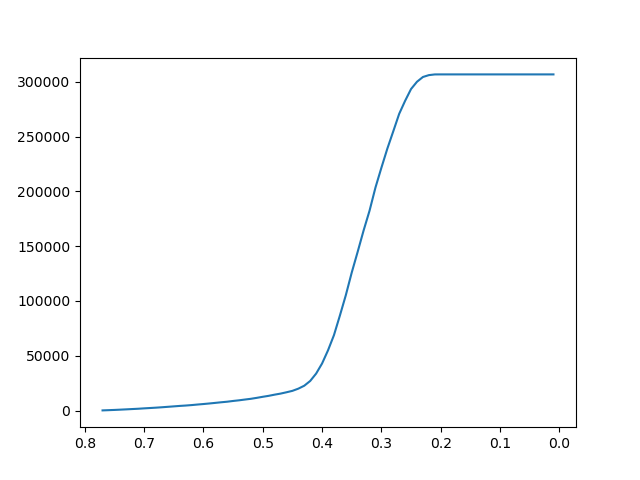

In [265]:
plt.figure()
plt.plot(bin_edges_reversed[:-1], cumulative_sum)
plt.gca().invert_xaxis()

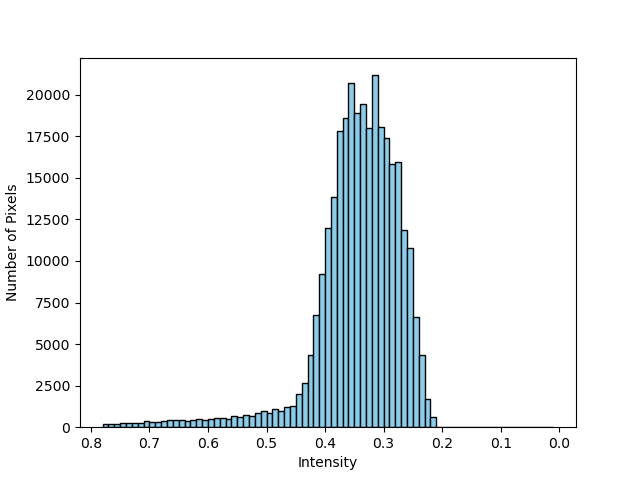

In [266]:
plt.figure()
plt.bar(bin_edges_reversed[:-1], hist_reversed, width=np.diff(bin_edges), edgecolor='black', align='edge', color='skyblue')
plt.xlabel('Intensity')
plt.ylabel('Number of Pixels')
plt.gca().invert_xaxis()
plt.show()

In [267]:
pip_IMC =  (cumulative_sum[1:] - cumulative_sum[:-1]) / cumulative_sum[1:]

In [268]:

pip_IMC.max()

0.5286783042394015

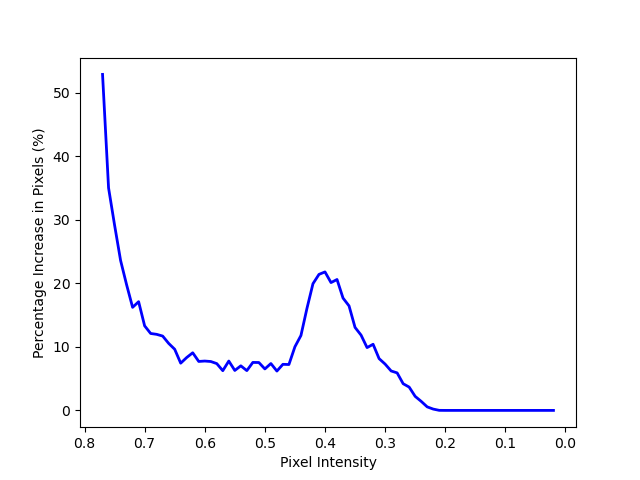

In [269]:
plt.figure()
plt.plot(bin_edges_reversed[:-2], pip_IMC*100, linewidth=2, color='blue')
plt.xlabel('Pixel Intensity')
plt.ylabel('Percentage Increase in Pixels (%)')
plt.gca().invert_xaxis()



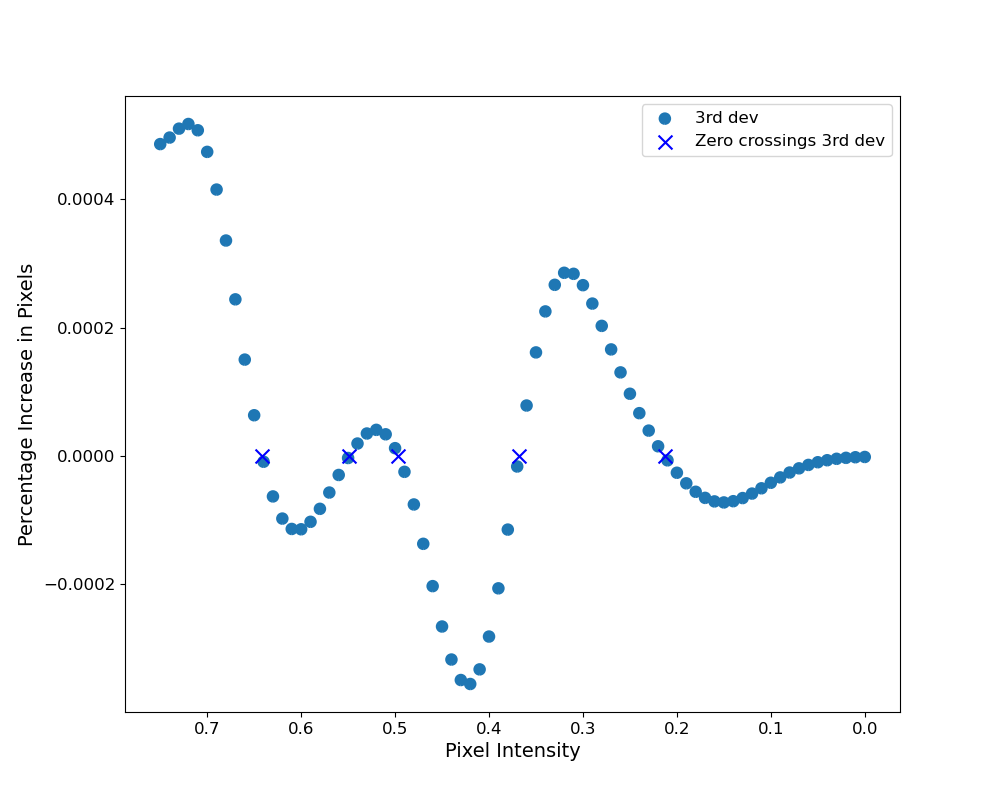

Zero crossings for pip_1: [0.51528728 0.37441941 0.05      ]
Zero crossings for pip_2: [0.70391909 0.43250916 0.29456186]
Zero crossings for pip_3: [0.64124344 0.54858455 0.49670547 0.36827095 0.21312082]


In [270]:
''' 
np.diff: Calculate the n-th discrete difference along the given axis.
The first difference is given by out[i] = a[i+1] - a[i] along the given axis, higher differences are calculated by using diff recursively. 

np.gradient: Return the gradient of an N-dimensional array.

The gradient is computed using second order accurate central differences in the interior
 points and either first or second order accurate one-sides (forward or backwards) differences at the boundaries. The returned gradient hence has the same shape as the input array.
'''

#pip_smoothed = filters.gaussian(pip_IMC, sigma=3)
#pip_1 = np.gradient(pip_smoothed)
#pip_2 = filters.gaussian(np.gradient(pip_1), sigma=3)
#pip_3 = filters.gaussian(np.gradient(pip_2), sigma=3)

pip_smoothed = gaussian_filter1d(pip_IMC, sigma=3)
pip_1 = np.gradient(pip_smoothed)
pip_2 = gaussian_filter1d(np.gradient(pip_1), sigma=4)
pip_3 = gaussian_filter1d(np.gradient(pip_2), sigma=3)



 


# Function to find zero crossings
def find_zero_crossings(x, y):
    """Finds approximate zero crossings using linear interpolation."""
    sign_changes = np.where(np.diff(np.sign(y)))[0]  # Indices where sign changes
    zero_crossings = x[sign_changes] - y[sign_changes] * (x[sign_changes + 1] - x[sign_changes]) / (y[sign_changes + 1] - y[sign_changes])
    return zero_crossings

# Find zero crossings
zero_pip_1 = find_zero_crossings(bin_edges_reversed[2:], pip_1)
zero_pip_2 = find_zero_crossings(bin_edges_reversed[2:], pip_2)
zero_pip_3 = find_zero_crossings(bin_edges_reversed[2:], pip_3)

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(bin_edges_reversed[2:], pip_3, label='3rd dev', linestyle='-.', linewidth=3)

# Plot zero crossings
plt.scatter(zero_pip_3, np.zeros_like(zero_pip_3), color='b', marker='x', label='Zero crossings 3rd dev', s=100)

# Labels and legend
plt.xlabel('Pixel Intensity', fontsize=14)
plt.ylabel('Percentage Increase in Pixels', fontsize=14)
plt.legend(fontsize=12)
plt.gca().invert_xaxis()
#plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Increase tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.show()

# Print zero crossings
print("Zero crossings for pip_1:", zero_pip_1)
print("Zero crossings for pip_2:", zero_pip_2)
print("Zero crossings for pip_3:", zero_pip_3)

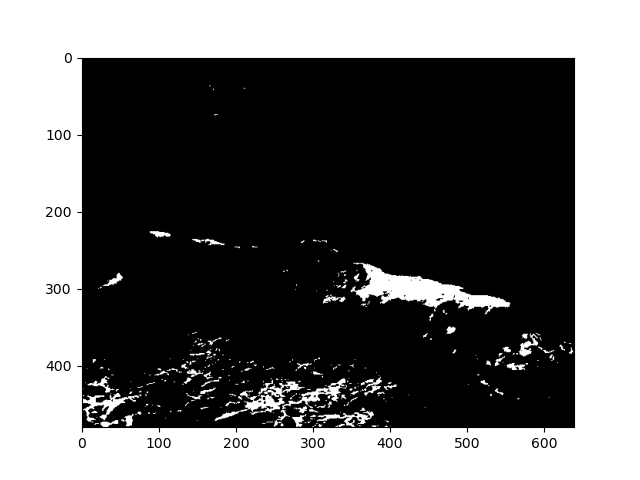

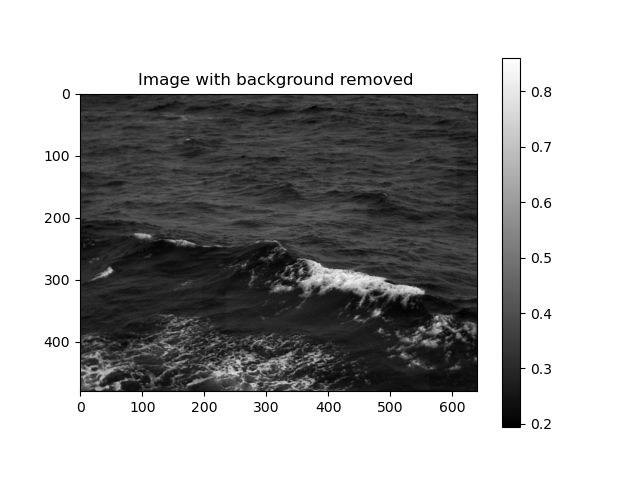

In [272]:
whitecap_mask = im_subtracted <0.49670547
plt.figure()
plt.imshow(whitecap_mask, cmap='binary')
plt.show()

plt.figure()
plt.clf()
plt.title('Image with background removed ')
plt.imshow(im_subtracted, cmap='gray')
plt.colorbar()
plt.show()

tried both approached, seems like this is the closest 